<a href="https://colab.research.google.com/github/RakshayGO/basic-ML-models/blob/main/CNN_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The convolutional layers take feature maps as their input and return a new feature map that reprsents the prescence of spcific filters from the previous feature map.

# getting data and initializing

In [2]:
%tensorflow_version 2.x 
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
#  LOAD AND SPLIT DATASET
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

It contains 60,000 32x32 color images with 6000 images of each class. Each image has 3 color channels (R/G/B) therefore the shape of 1 image is (32,32,3)

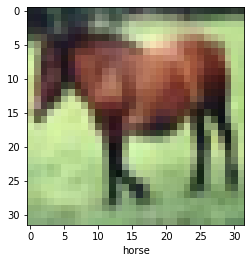

In [4]:
IMG_INDEX = 7  # change this to look at other images

plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

# Building convolutional base

A common architecture for a CNN is a stack of Conv2D and MaxPooling2D layers followed by a few denesly connected layers. To idea is that the stack of convolutional and maxPooling layers extract the features from the image. Then these features are flattened and fed to densly connected layers that determine the class of an image based on the presence of features.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

**Layer 1**

The input shape of our data will be 32, 32, 3 and we will process 32 filters of size 3x3 over our input data. We will also apply the activation function relu to the output of each convolution operation.

**Layer 2**

This layer will perform the max pooling operation using 2x2 samples and a stride of 2.


The next set of layers do very similar things but take as input the feature map from the previous layer. They also increase the number of filters from 32 to 64. We can do this as our data shrinks in spacial dimensions as it passed through the layers, meaning we can afford (computationally) to add more filters.

# Add dense layers for classifier

 Now we need to take these extracted features and add a way to classify them. This is why we add the following layers to our model.

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

## <font color="magenta"> note </font>

 after flattening our total nodes were 1024 (4 * 4 * 64), now when these go into a dense layer of 64 nodes, all 1024 + 1(bias) get mapped to these 64 feature nodes, making total parameters for this dense layer as (1025 * 64) = 65600

However Conv2D layers dont necessarily map everything to evverything so math might not fit, but it's aproximate.


 

#Data Augmentation (not used here)
To avoid overfitting and create a larger dataset from a smaller one we can use a technique called data augmentation. This is simply performing random transofrmations on our images so that our model can generalize better. These transformations can be things like compressions, rotations, stretches and even color changes. 

Fortunately, keras can help us do this.
Couldn't apply it here because well the dataset is imported from keras, we dont have a local dataset. I guess we can add to the train_images array but idk how


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

# creates a data generator object that transforms images
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

# pick an image to transform
test_img = train_images[20]
img = image.img_to_array(test_img)  # convert image to numpy arry
img = img.reshape((1,) + img.shape)  # reshape image

i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i > 4:  # show 4 images
        break

plt.show()

# training

The `from_logits=True` attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution. However the loss function applies it by own, so better just use apply it in output layer.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 10s 5ms/step - loss: 1.5148 - accuracy: 0.4485 - val_loss: 1.2025 - val_accuracy: 0.5730
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1331 - accuracy: 0.6011 - val_loss: 1.0819 - val_accuracy: 0.6180
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9724 - accuracy: 0.6606 - val_loss: 1.0014 - val_accuracy: 0.6497
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8687 - accuracy: 0.6949 - val_loss: 0.9020 - val_accuracy: 0.6857
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7930 - accuracy: 0.7229 - val_loss: 0.8569 - val_accuracy: 0.7038
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7393 - accuracy: 0.7399 - val_loss: 0.8630 - val_accuracy: 0.6984
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6866 - accuracy: 0.7584 - val_loss: 0.8529 - val_accuracy

In [10]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

313/313 - 1s - loss: 0.8489 - accuracy: 0.7167 - 734ms/epoch - 2ms/step
0.71670001745224


# making predictions

In [14]:
predictions = model.predict(test_images)

In [16]:
import numpy as np

ship


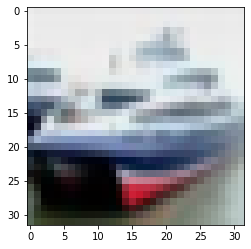

In [20]:
print(class_names[np.argmax(predictions[1])])
plt.figure()
plt.imshow(test_images[1])
plt.grid(False)
plt.show()